# housing prediction
- Predict final sales prices of residential homes in Ames, Iowa
- 80 explanatory variables describing every aspect of residential homes 
- data from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

## import data and library.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
all_df = pd.concat((train.iloc[:,:-1],test)) # combine test and train without sale price.
y_train = train["SalePrice"] 


In [11]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

In [12]:
all_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [13]:
# drop ID
all_df.drop('Id',axis=1,inplace=True)

In [17]:
nansum = all_df.isnull().sum().sort_values(ascending=False)
nansum.head(20)/all_df.shape[0]


PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageCond      0.054471
GarageQual      0.054471
GarageYrBlt     0.054471
GarageFinish    0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
BsmtHalfBath    0.000685
dtype: float64

PoolQC, MiscFeature,Alley,Fence,FireplaceQu,and LotFrontage are missing >16% of values.
delete them

In [19]:
all_df.drop(columns=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage'],inplace=True)

## explore

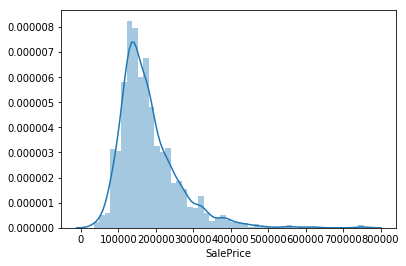

In [49]:
# analyzing saleprice
sns.distplot(train.SalePrice);
plt.savefig('./images/saleprice_dist.png')


slightly deviate from the normal distribution with some positive skewness.
unimodal.

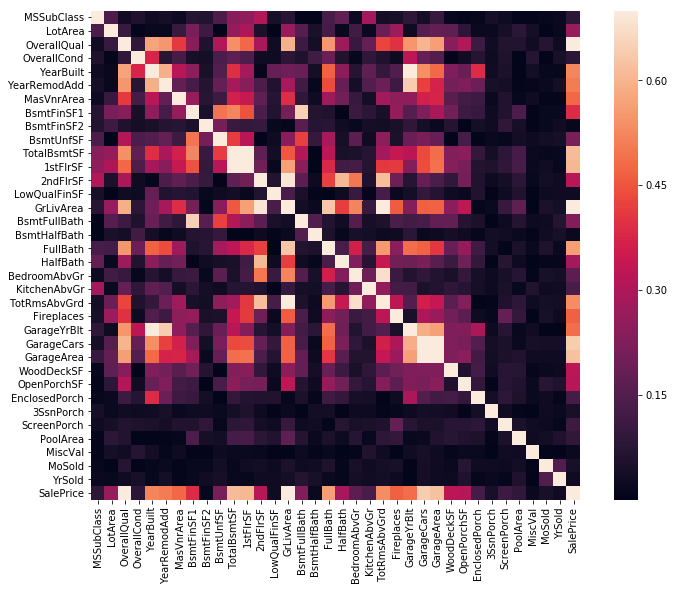

In [47]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(abs(corrmat), vmax=.7, square=True)
plt.savefig('./images/corrmat.png')

 we see a collinearity of TotalBsmtSF and 1stFlrSF
 also features regarding garage.
 
 

## data preprocessing

### check for skewness

In [22]:
# getting columns with numerical value
numeric_feats = all_df.dtypes[all_df.dtypes != "object"].index
numeric_feats.shape

(35,)

In [23]:
# check how many of them have skewness above 0.75
from scipy.stats import skew
skewed_feats = all_df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats.shape

(21,)

In [29]:
# fig = plt.figure(figsize=(10,10))
# for counter, value in enumerate(skewed_feats):
    
#     plt.subplot(5, 5, counter+1)
#     sns.distplot(train[value].dropna())

In [24]:
# do Log transform to minimize skewness
all_df[skewed_feats] = np.log1p(all_df[skewed_feats])

In [25]:
y_train = np.log1p(y_train)

In [32]:
# fig = plt.figure(figsize=(10,10))
# for counter, value in enumerate(skewed_feats):
    
#     plt.subplot(5, 5, counter+1)
#     sns.distplot(train[value].dropna())

### change categorial to dummy

In [26]:
all_df = pd.get_dummies(all_df.iloc[:,:-1])


In [27]:
all_df.shape

(2919, 263)

### fill  NaN with mean

In [28]:
all_df = all_df.fillna(all_df.mean())


### preparing data for modeling

In [29]:
#create matrices for sklearn:
X_train = all_df[:train.shape[0]]
X_test = all_df[train.shape[0]:]

## model
- use L1 and L2 regularization

### Ridge

(0.8961567395904373, 5)

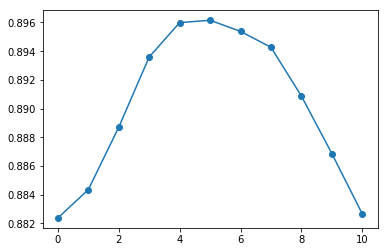

In [30]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV,Lasso
from sklearn.model_selection import cross_val_score

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge =[]
for i in alphas:
    clf = Ridge(alpha=i,random_state=1)
    cv = cross_val_score(clf, X_train, y_train).mean()
    cv_ridge.append(cv)
plt.plot(cv_ridge,'-o')
max(cv_ridge),alphas[np.argmax(cv_ridge)]

In [31]:
model_Ridge= RidgeCV(alphas=[0.1,0.2]).fit(X_train, y_train)
coef_Ridge = pd.Series(model_Ridge.coef_, index = X_train.columns)
abs_coef_Ridge = abs(coef_Ridge).sort_values(ascending=False)
abs_coef_Ridge

RoofMatl_ClyTile        1.210077
Condition2_PosN         0.499838
GrLivArea               0.431624
MSZoning_C (all)        0.336035
RoofMatl_Membran        0.271579
RoofMatl_WdShngl        0.261986
GarageQual_Ex           0.246166
Condition2_PosA         0.217316
RoofMatl_Metal          0.193539
Exterior1st_BrkComm     0.180076
Functional_Sev          0.169383
Functional_Maj2         0.161061
RoofStyle_Shed          0.149167
Heating_Grav            0.147440
Condition2_RRNn         0.146337
Condition2_Feedr        0.146211
GarageCond_Ex           0.145734
Neighborhood_StoneBr    0.144831
Condition2_RRAe         0.144568
BsmtCond_Fa             0.143519
RoofMatl_CompShg        0.142570
RoofMatl_WdShake        0.134436
RoofMatl_Roll           0.130668
BsmtCond_Gd             0.125905
BsmtQual_TA             0.125376
Functional_Typ          0.124528
MSZoning_FV             0.121358
BsmtCond_TA             0.120487
BsmtQual_Gd             0.119824
KitchenAbvGr            0.119101
          

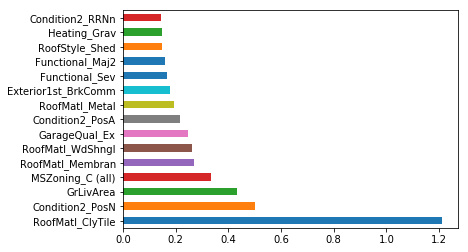

In [32]:
abs_coef_Ridge[0:15].plot(kind='barh')

### Lasso

[0.8972244975820738,
 0.9023860603598727,
 0.9020498120027326,
 0.8980003724821719,
 0.8551532720988778]

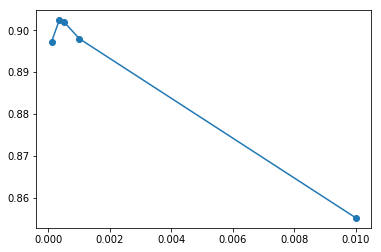

In [33]:
alphas = [1e-4,3.5e-4,5e-4, 1e-3,1e-2]
cv_lasso =[]
for i in alphas:
    cv = cross_val_score(Lasso(alpha=i), X_train, y_train).mean()
    cv_lasso.append(cv)
plt.plot(alphas,cv_lasso,'-o')
cv_lasso

In [43]:
model_lasso = LassoCV(alphas = [1e-4,3.5e-4,5e-4, 1e-3,1e-2]).fit(X_train, y_train)
cross_val_score(model_lasso,X_train, y_train,scoring='neg_mean_squared_error'),model_lasso.alpha_

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(array([-0.01180266, -0.01800145, -0.01709474]), 0.00035)

In [44]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
abs(coef).sort_values(ascending=False)

RoofMatl_ClyTile        0.985559
GrLivArea               0.428267
MSZoning_C (all)        0.345651
Condition2_PosN         0.320301
Neighborhood_StoneBr    0.121790
Neighborhood_Crawfor    0.105903
Functional_Maj2         0.089496
Neighborhood_NoRidge    0.082988
RoofMatl_WdShngl        0.078652
Functional_Typ          0.078313
Neighborhood_NridgHt    0.076599
LotArea                 0.074983
Exterior1st_BrkFace     0.072362
KitchenQual_Ex          0.064521
Neighborhood_Edwards    0.056450
OverallQual             0.050700
BsmtQual_Ex             0.050067
Heating_Grav            0.049661
Condition1_RRAe         0.049197
Neighborhood_BrkSide    0.045709
Condition1_Norm         0.043325
OverallCond             0.043104
SaleType_COD            0.041821
Neighborhood_Somerst    0.039981
BsmtExposure_Gd         0.039805
Heating_GasW            0.039227
MSZoning_RM             0.037017
KitchenAbvGr            0.036610
GarageCond_Fa           0.035159
GarageCars              0.035066
          

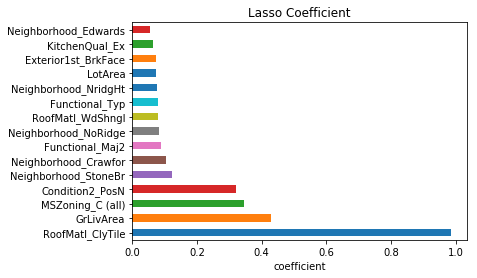

In [48]:
abscoef = abs(coef).sort_values(ascending=False)
abscoef[0:15].plot(kind='barh')
plt.title('Lasso Coefficient')
plt.xlabel('coefficient')
plt.savefig('./images/coef_lasso.png')


Roof material:ClyTile, GrLivArea: Above grade (ground) living area square feet,MSZoning in C (Commercial), Condition2: Proximity Near positive off-site feature--park, greenbelt, etc.
		
are important features that decide housing price.

In [100]:
### output this to Kaggle
las = Lasso(alpha= 0.00035).fit(X_train,y_train)
Y_predi = las.predict(X_test)
Y_predi = np.expm1(Y_predi) # reverse to normal value
submission = pd.DataFrame({'Id':test['Id'],"SalePrice":Y_predi})
submission.to_csv("submission_lasso.csv", index = False)

In [107]:
rid = Ridge(alpha= 0.1).fit(X_train,y_train)
Y_predi = rid.predict(X_test)
Y_predi = np.expm1(Y_predi) # reverse to normal value
submission = pd.DataFrame({'Id':test['Id'],"SalePrice":Y_predi})
submission.to_csv("submission_rid.csv", index = False)

### elastic

In [ ]:
alphas = [1e-4,3.5e-4,5e-4, 1e-3,1e-2]
cv_lasso =[]
for i in alphas:
    cv = cross_val_score(Lasso(alpha=i), X_train, y_train).mean()
    cv_lasso.append(cv)
plt.plot(alphas,cv_lasso,'-o')
cv_lasso

## try other models

### light gbm

In [74]:
import lightgbm as lgb
lgb_r = lgb.LGBMRegressor()
lgb_r.fit(X_train,y_train)
Y_predi = lgb_r.predict(X_test)
Y_predi = np.expm1(Y_predi) # reverse to normal value
submission = pd.DataFrame({'Id':test['Id'],"SalePrice":Y_predi})
submission.to_csv("submission_lgb.csv", index = False)


In [37]:
from sklearn.ensemble import RandomForestRegressor 
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train,y_train)
Y_predi = forest_reg.predict(X_test)
Y_predi = np.expm1(Y_predi) # reverse to normal value
submission = pd.DataFrame({'Id':test['Id'],"SalePrice":Y_predi})
submission.to_csv("submission_forest.csv", index = False)

In [42]:
-cross_val_score(forest_reg,X_train, y_train,scoring='neg_mean_squared_error')

array([0.02155741, 0.02620729, 0.02419922])